# Markov Chain Monte Carlo

---

In this notebook, we go over several Monte Carlo and Markov Chain Monte Carlo (MCMC) methods  so as to illustrate some of their advantages and disadvantages over other methods. 

In [1]:
#Some libraries that we will be using.
from __future__ import print_function, division
import numpy as np
from scipy.stats import norm, multivariate_normal, rv_continuous, uniform, mvn
from IPython import display
import math 
import time

#Configure the matplotlib backend as plotting inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Enables latex
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':'30'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

---

## 1. Independent Sampling

The first type of Monte Carlo methods utilise \textit{independent sampling} whereby each new sample is independent of all previous ones.

---
### 1.1 Simple Monte Carlo
---

Simple Monte Carlo methods just involve straight-forward sampling from an easy-to-sample distribution (such as a Normal distribution) so as to obtain an estimate of an expectation or to make an approximation of the distribution itself. 

Here we present two examples: Sampling to obtain the posterior distribution of the gradient parameter of a linear model and sampling from a Mixture of Gaussians (MoG) so as to approximate the expectation of a linear function under this distribution.

#### 1.1.1 Linear Regression Example

$$
\newcommand\given[1][]{\:#1\vert\:}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
$$

In this linear regression example, we use a model of the form:

$$
y = \theta x + \epsilon
$$ 

where $\epsilon \sim \mathcal{N}(0,\sigma_{y}^{2})$.

We then execute the following procedure to obtain an approximate to the posterior distribution $p(\theta\given{y})$:

- We sample a value of $\theta$ from the prior $\mathcal{N}(\mu_{\theta},\sigma_{\theta}^{2})$, make a noisy prediction with this $\theta_{s}$: $\mathbf{y}_{pred} = \theta_{s}x + \eta$, where $\eta \sim \mathcal{N}(0,\sigma_{\eta}^{2})$. 
- If $\norm{\mathbf{y}-\mathbf{y}_{pred}}^{2} < \alpha^{2}$ we accept the sample otherwise we reject it. ($\alpha^{2}$ is a parameter we manually select).

The algorithm is then executed for the specified number of samples.

---

First we set up some functions that we will use.

In [2]:
def calcLikelihood(y, theta, x, sigma):
    """
        Calculates likelihood of parameter 'sigma'
    """
    
    N = len(y)
    
    #Use log-likelihood to avoid rounding-off errors
    log_L = -(N/2)*math.log(2*math.pi*(sigma**2)) - \
            (1/(2*(sigma**2)))*np.dot(y-theta*x,y-theta*x)
        
    return np.exp(log_L)


The main procedure:

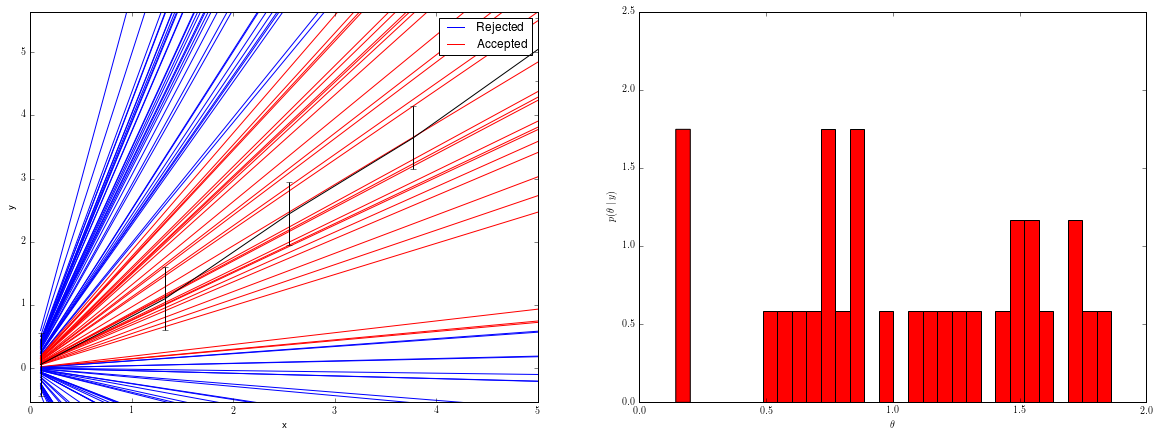

Iteration number:  99
Theta:  0.035683151086
y:  [ 0.05580915  1.09489841  2.44006228  3.64574342  5.04120277]
y_pred:  [ 0.2581497   0.30186156  0.34557342  0.38928528  0.43299714]
MSE:  7.37936229469


AttributeError: Unknown property lanel

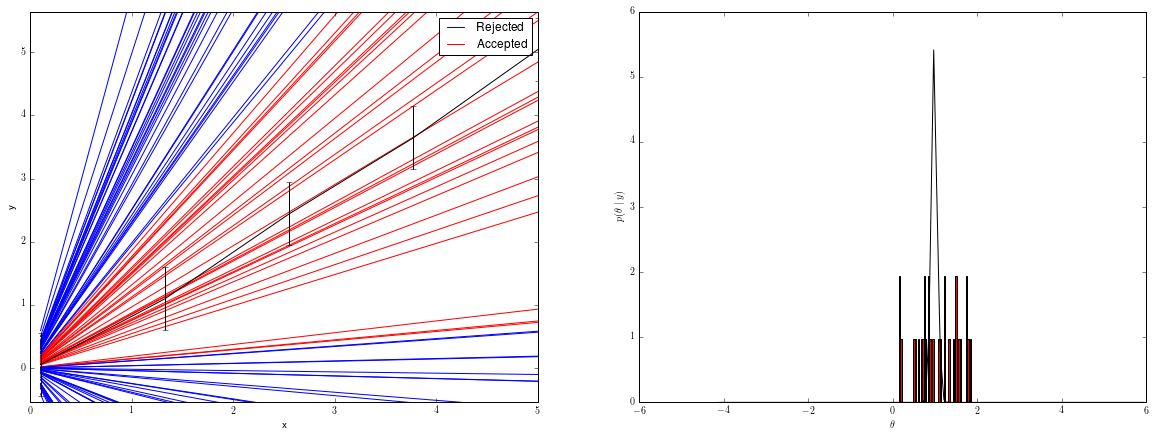

In [10]:
   
theta_g = 1.0   #Theta to generate data
print("Generative theta is: ", theta_g)

#Prior parameters
m_prior = 1.0
sigma_prior = 2.0

#Other params
num_samples = 100  #Number of samples from prior
sigma_y = 0.5      #Noise standard deviation
N = 5             #Num data points
sigma_n = 0.5     #Prediction noise

#Observations
x = np.linspace(0.1,5,N)                      
y = theta_g*x + sigma_y*np.random.randn(N)  

#Sampled thetas and corresponding posteriors 
thetas = np.zeros(num_samples)   
posteriors = np.zeros_like(thetas)


#Set up figure
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(20,7)
ax_data = axes[0]
ax_post = axes[1]

ax_data.errorbar(x,y,yerr=sigma_y,color='k',ecolor='k',zorder=100) #Data with error bars
ax_data.set_ylim(np.amin(y)-.1-sigma_y,np.amax(y)+.1+sigma_y)
ax_data.set_xlabel(r'x')
ax_data.set_ylabel(r'y')
ax_post.set_xlabel(r'$\theta$')
ax_post.set_ylabel(r'$p(\theta \mid y)$')


accepted = []
rejected = []
alpha = 5.7
runTillEnd = False
for i in range(num_samples):
    
    thetas[i] = m_prior + sigma_prior*np.random.randn()#1.0 + np.random.randn()
    
    y_pred = thetas[i]*x + sigma_n*np.random.randn()
    
    if np.linalg.norm(y-y_pred)**2 < alpha**2:
        if len(accepted) > 0:
            del ax_post.patches[:]
        accepted.append(thetas[i])
        ax_post.hist(accepted,min(len(accepted),50),color='red',normed=True)
        if i==0 or len(accepted) == 1:
            ax_data.plot(x,thetas[i]*x,'r-',label=r'Accepted')
            ax_data.legend()
        else:
            ax_data.plot(x,thetas[i]*x,'r-')
    else: 
        rejected.append(thetas[i])
        if i==0 or len(rejected) == 1:
            ax_data.plot(x,thetas[i]*x,'b-',label=r'Rejected')
            ax_data.legend()
        else:
            ax_data.plot(x,thetas[i]*x,'b-')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print("Iteration number: ",i)
    print("Theta: ",thetas[i])
    print("y: ",y)
    print("y_pred: ",y_pred)
    print("MSE: ", (np.linalg.norm(y-y_pred)**2)/len(y))
    if not runTillEnd:
        if input("Press enter to continue. Type 'rte' to run simulation to end. ") == "rte":
            runTillEnd = True

    
#Sort 'thetas'
sortidx = np.argsort(thetas)
thetas = thetas[sortidx]

#True posterior
m_post = (m_prior*sigma_y**2 + np.dot(y,x)*sigma_prior**2)/(sigma_y**2 + np.dot(x,x)*sigma_prior**2)
sigma_post = math.sqrt(((sigma_y*sigma_prior)**2)/(sigma_y**2 + np.dot(x,x)*sigma_prior**2))
true_posterior = norm.pdf(thetas,loc=m_post,scale=sigma_post)


#Plot true posterior
del ax_post.patches[:]
ax_post.plot(thetas, true_posterior,'k-',zorder=100,label=r'True post')
ax_post.hist(accepted,50,color='red',normed=True,zorder=99,lanel=r'Samples')
ax_post.set_xlim((-0.5,2.5))
ax_post.set_ylim((0,2.1))
ax_post.legend()


display.clear_output(wait=True)
print("Variance (true): ",sigma_post**2)
print("Mean (true): ", m_post)
print("True theta: ",theta_g)



##### Problems

1. Now try changing the number of data points so as to see how the posterior changes.

2. Experiment with different priors

---
#### 1.1.2 Monte Carlo Integration
---

In this example, we calculate the expectation of a linear function of the form, $y = ax + b$, under a Mixture of Gaussians distribution.

First let us set up the classes we will use throughout most of the subsequent examples.

In [4]:
from sklearn.preprocessing import normalize

class MixtureOfGaussians(rv_continuous):
    """
        Defines a Mixture of Gaussians distribution
    """
    def __init__(self, K, means, sd, weights=None):
        """
            K - No. of means
            means - The means for each Gaussian. Should have shape (K,) or (K,1).
            sd - The standard deviations for each component. Should have shape (K,) or (K,1).
            weight - Mixture weights for each Gaussian - shape(K,) or (K,1).
        """
        self.K = K
        self.means = np.array(means)
        self.sd = np.array(sd)
        if weights == None:
            self.weights = np.ones(K)/K
        else:
            self.weights = weights
            
        rv_continuous.__init__(self)
        
    def _pdf(self, x):
        """
            Evaluate the pdf at the given x
        """
        
        pdf_x = 0
        
        for i in range(self.K):
            pdf_x += self.weights[i]*norm.pdf(x,loc=self.means[i],scale=self.sd[i])
        
        return pdf_x
    
    def _cdf(self, x):
    
        cdf_x = np.zeros_like(x)
        
        for i in range(self.K):
            cdf_x += self.weights[i]*norm.cdf(x,loc=self.means[i],scale=self.sd[i])
        
        return cdf_x 
        

class Phi(object):
    """
        Class to specify a linear function and its call behaviour
        
        Attributes:
            m - Gradient
            b - Bias
    """
    def __init__(self, m, b):
        self.m = m
        self.b = b
    
    def __call__(self,x):
        return self.m*x+self.b



The following example simply makes a sample from the MoG and updates the first plot so as to update the samples histogram which is normalised so that it can be compared to the true distribution (blue). The second plot gives the linear function whose expectation is being calculated and the third plot shows the running average estimate of the mean of the linear function i.e. we calculate:

$$
\mathbb{E}[\phi(x)] \approx \hat{\phi} = \frac{1}{T}\sum_{\tau=1}^{T} \phi(x^{(\tau)})    
$$

where  $x^{(\tau)} \sim p(x)$ (our MoG distribution) and $\phi(.)$ is the linear function.

Mean estimate:  1.77202157262
True mean:  2.0000000000000058


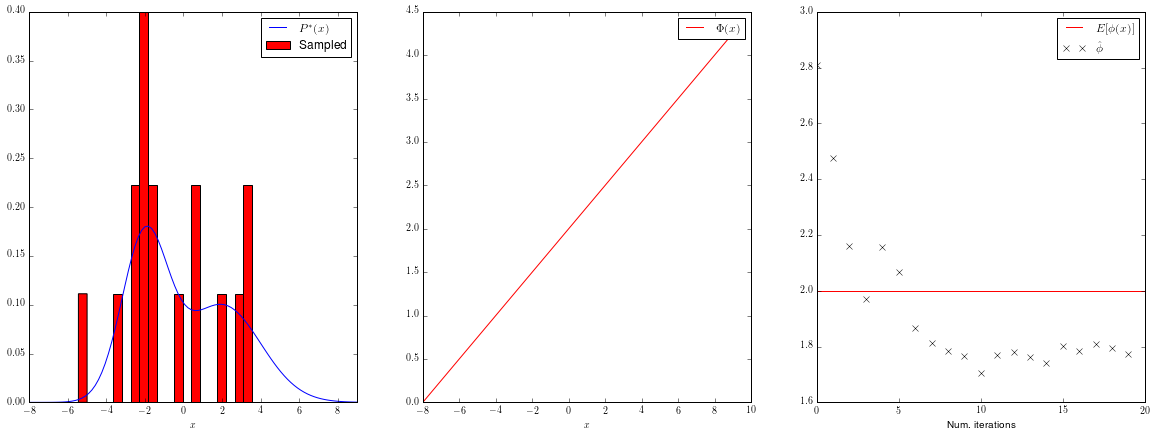

In [11]:

x_min = -8
x_max = 9
x = np.linspace(x_min,x_max,100)

#Set up distribution P*(x) and linear function Phi(x)
P_x = MixtureOfGaussians(2, [-2, 2], [1.2, 2],weights=[0.5, 0.5])
p_x = P_x.pdf(x)
p_x = p_x
p_x_norm = normalize(p_x,norm='l1').reshape(-1,1)[:,0]  #Normalized distribution
phi = Phi(m=0.25,b=2)
phi_x = phi(x)

#Set up figure
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,7)
ax_distr = axes[0]
ax_linfunc = axes[1]
ax_mean = axes[2]

#Plot
ax_distr.plot(x,p_x,'b',label=r'$P^{*}(x)$')
ax_distr.set_xlabel(r'$x$')
ax_distr.set_xlim(xmin=x_min,xmax=x_max)
ax_distr.set_ylim(ymax=0.4)
ax_linfunc.plot(x,phi_x,'r',label=r'$\Phi(x)$')
ax_linfunc.set_xlabel(r'$x$')
ax_mean.axhline(P_x.expect(phi),color='r',label=r'$\mathbb{E}[\phi(x)]$')
ax_mean.set_xlabel(r'Num. iterations')

num_samples = 20  
mean_est = 0        #Running average of E[Phi(x)]
samples =[]

runTillEnd = False
for i in range(num_samples):
    
    sample = P_x.rvs()
    samples.append(sample)
    
    mean_est = (i/(i+1))*mean_est + (phi(sample))/(i+1)
    
    #Delete previous histogram plot
    if i > 0:
        del ax_distr.patches[:]

    display.clear_output(wait=True)
    
    ax_distr.hist(samples,min(i+1,50),color='red',normed=True,label=r'Sampled')    
    ax_mean.plot(i,mean_est,'kx',label=r'$\hat{\phi}$') 
    
    if i==0:
        ax_distr.legend()
        ax_linfunc.legend()
        ax_mean.legend()
        
    display.display(plt.gcf())
    
    if not runTillEnd:
        if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
            runTillEnd = True

display.clear_output(wait=True)
print("Mean estimate: ", mean_est)
print("True mean: ", P_x.expect(phi))


---
### 1.2 Rejection Sampling
---

The problem with the previous naive Monte Carlo methods is that if we use a distribution that places minimal weight on parts of $\phi(\mathbf{x})$ that contribute greatly to $\mathbb{E}[\mathbf{x}]$, we might take a long time for the expectation to converge to the true value.

We therefore have to develop new methods that are able to provide good estimates of $\mathbb{E}[\mathbf{x}]$ quickly.

One method is \textbf{Rejection sampling} which provides a slight improvement over the naive MC but brings in its own advantages.

We first find a tractable distribution $q(\mathbf{x})$ and $c\geq1$ such that $\forall\mathbf{x}$, $cq(\mathbf{x}) \geq p(\mathbf{x})$. The algorithm then works as follows:

\begin{itemize}
\item We generate samples from $q(\mathbf{x})$
\item Accept samples with probability $p(\mathbf{x})/cq(\mathbf{x})$, otherwise reject.
\item Form a Monte Carlo estimate from the accepted samples. In this case, we use it to update a running average of accepted samples.
\end{itemize}

---

First we set up classes and functions that will be of use in later examples.

In [6]:
class PropDistr(rv_continuous):
    """
        Defines a proposal distribution based on given parameters. 
        Only Gaussian and Uniform distributions are permitted.
    """
    
    def __init__(self, D, distr_type='gaussian',mean=0,sd=1):
        self.D = D
        self.mean = mean
        self.sd = sd
        self.distrtype = distr_type
        
        if D == 1 and distr_type == 'gaussian':
            self.normdistr = norm
        else:
            self.normdistr = multivariate_normal
            
        rv_continuous.__init__(self)
    
    def _pdf(self, x):    
        if self.distrtype == 'uniform':
            p_x = 1
            for d in self.D:
                p_x *= uniform.pdf(x,loc=self.mean,scale=self.sd)
            return p_x
        else: #self.distr == 'gaussian'
            return self.normdistr.pdf(x,self.mean,self.sd)
        
    
    def _cdf(self,x):
        if self.distrtype == 'uniform':
            cdf_x = 1
            for d in self.D:
                cdf_x *= uniform.cdf(x,loc=self.mean,scale=self.sd)
            return cdf_x
        else: #self.distr == 'gaussian'
            if self.D == 1:
                return norm.cdf(x,loc=self.mean,scale=self.sd)
            else:
                #Select lower limits to be far away from mean so that CDF estimate isn't too inaccurate
                low = np.array([-1.0]*self.D)
                thresh = 1e-6  #Approx 5 s.d.s away from mean 
                while self._pdf(low) > thresh:
                    low = 2*low
                return mvn.mvnun(low,x,self.mean,self.sd)[0]


KeyboardInterrupt: 

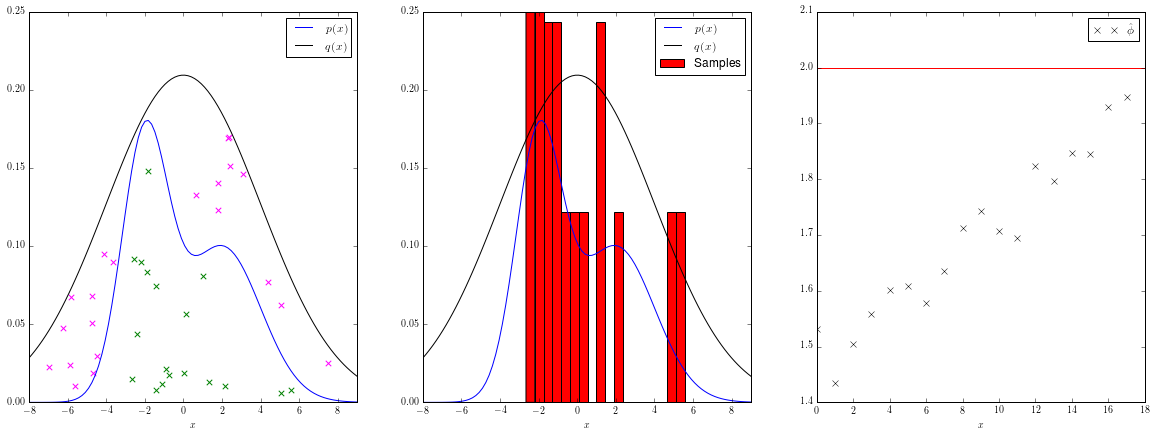

In [12]:

#Set up distributions and functions
target_distr = MixtureOfGaussians(2, [-2, 2], [1.2, 2])
prop_distr = PropDistr(1,distr_type='gaussian',mean=0,sd=4)
phi = Phi(m=0.25,b=2)

c = 1.    #Scaling for q(x)

#X-axis range
x_min = -8
x_max = 9
N = 100
x = np.linspace(x_min,x_max,N)


#Keep on adjusting 'c' so as to satisfy cq(x) > p(x) for all x
print("Select an appropriate c: ")
usr_input = 'N'
while usr_input != 'Y':
    plt.clf()
    plt.plot(x,target_distr.pdf(x),'r',label=r'$p(x)$')
    plt.plot(x,c*prop_distr.pdf(x),'b',label=r'$cq(x)$')
    display.display(plt.gcf())
    print("Current c: ", c)
    c = float(input("Enter a value for c: "))
    display.clear_output(wait=True)
    if (any((target_distr.pdf(x)-c*prop_distr.pdf(x)) > 0)):
        print("c*q(x) is not greater than p(x) for all x!")
    plt.clf()
    plt.plot(x,target_distr.pdf(x),'r',label=r'$p(x)$')
    plt.plot(x,c*prop_distr.pdf(x),'b',label=r'$cq(x)$')
    display.display(plt.gcf())
    usr_input = input("Done?(Y/N): ")

plt.clf()    
display.clear_output(wait=True)    
  
#Evaluate distributions and phi(x) at number of points
p_x = target_distr.pdf(x)
q_x = prop_distr.pdf(x)
cq_x = c*q_x  #Scale q(x)
phi_x = phi(x)


#Set up figure and make initial plots
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,7)
ax_distr = axes[0]
ax_linfunc = axes[1]
ax_mean = axes[2]

ax_distr.plot(x,p_x,'b',label=r'$p(x)$')
ax_distr.plot(x,cq_x,'k',label=r'$q(x)$')
ax_distr.legend()
ax_distr.set_xlim(xmin=x_min,xmax=x_max)
ax_distr.set_ylim(ymin=0.0,ymax=0.25)
ax_distr.axhline(0,color='k')
ax_distr.set_xlabel(r'$x$')
#ax_linfunc.plot(x,phi_x,'r',label=r'$\Phi(x)$')
ax_linfunc.plot(x,p_x,'b',label=r'$p(x)$')
ax_linfunc.plot(x,cq_x,'k',label=r'$q(x)$')
ax_linfunc.set_xlim(xmin=x_min,xmax=x_max)
ax_linfunc.set_ylim(ymin=0.0,ymax=0.25)
ax_linfunc.set_xlabel(r'$x$')
ax_mean.axhline(target_distr.expect(phi),color='r')
ax_mean.set_xlabel(r'$x$')


max_accepts = 20     #The number of accepts we want
num_accepts = 0
mean_est = 0      
num_iters = 0
mean_ests = []
samples_accept = np.array([[]]).reshape(0,2)
samples_reject = np.array([[]]).reshape(0,2)


runTillEnd = False
while num_accepts < max_accepts:
    
    sample = prop_distr.rvs()
    
    u = np.random.rand()
    
    p_samp = target_distr.pdf(sample)
    qs_samp = c*prop_distr.pdf(sample)
    
    display.clear_output(wait=True)
    if u < p_samp/qs_samp:
        mean_est = (num_accepts/(num_accepts+1))*mean_est + (phi(sample))/(num_accepts+1)
        mean_ests.append(mean_est)
        
        samples_accept = np.append(samples_accept,[[sample, u*qs_samp]],axis=0)
        
        if num_accepts > 0:
            del ax_linfunc.patches[:]
        
        ax_distr.scatter(sample,u*qs_samp,marker='x',s=30,color='green')
        ax_linfunc.hist(samples_accept[:,0],min(num_accepts+1,50),color='red',normed=True,label=r'Samples')
        ax_mean.plot(num_accepts,mean_est,'kx',label=r'$\hat{\phi}$')
        
        if num_accepts == 0:
            ax_linfunc.legend()
            ax_mean.legend()
            
        num_accepts += 1
    else:
        samples_reject = np.append(samples_reject,[[sample, u*qs_samp]],axis=0)
        ax_distr.scatter(sample,u*qs_samp,marker='x',s=30,color='magenta')
         
    display.display(plt.gcf())
    
    num_iters += 1
    
    if not runTillEnd:
        if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
            runTillEnd = True
            
display.clear_output(wait=True)

print("Accepted: ", samples_accept.shape[0])
print("Rejected: ", samples_reject.shape[0])
print("Mean estimate: ", mean_est)
print("True mean: ", target_distr.expect(phi))
print("Num iterations: ", num_iters)

##### Problems

1. Observe how the number of iterations to obtain a desired number of accepts changes with the value of $c$ i.e. how close $cq(\mathbf{x})$ is to $p(\mathbf{x})$.

---
### 1.3 Importance Sampling
---

Another method that is very similar to rejection sampling is \textbf{Importance sampling}. It is similar to rejection sampling in that it is only a method for estimating the expectation of a function as opposed to sampling from $p(x)$.

We find a tractable distribution $q(\mathbf{x}) \approx p(\mathbf{x})$ such that $q(\mathbf{x}) > 0$ whenever $p(\mathbf{x}) > 0$. We then form the Importance sampling estimate as:

$$
\int \phi(x)\frac{p(\mathbf{x})}{q(\mathbf{x})}q(\mathbf{x})\mathrm{d}\mathbf{x} \approx \hat{\phi} = \frac{1}{T}\sum_{\tau=1}^{T}\phi(\mathbf{x}^{(\tau)})\underbrace{\frac{p(\mathbf{x}^{(\tau)})}{q(\mathbf{x}^{(\tau)})}}_\text{$w(\mathbf{x}^{(\tau)})$}
$$

where $\mathbf{x}^{(\tau)} \sim q(\mathbf{x})$ and $w(\mathbf{x}^{(\tau)})$ are called the \textit{importance weights}.

There is also a more general version which doesn't require knowing how $q(\mathbf{x})$ normalizes:

$$
\hat{\phi} = \frac{\sum_{\tau}\phi(\mathbf{x}^{(\tau)})w(\mathbf{x}^{(\tau)})}{\sum_{\tau}w(\mathbf{x}^{(\tau)})}
$$

where $w(\mathbf{x}^{(\tau)}) = \frac{p(\mathbf{x})}{q^{*}(\mathbf{x})}$ ($q^{*}(\mathbf{x})$ is the unnormalized $q(\mathbf{x})$) and $\mathbf{x}^{(\tau)} \sim q(\mathbf{x})$

KeyboardInterrupt: 

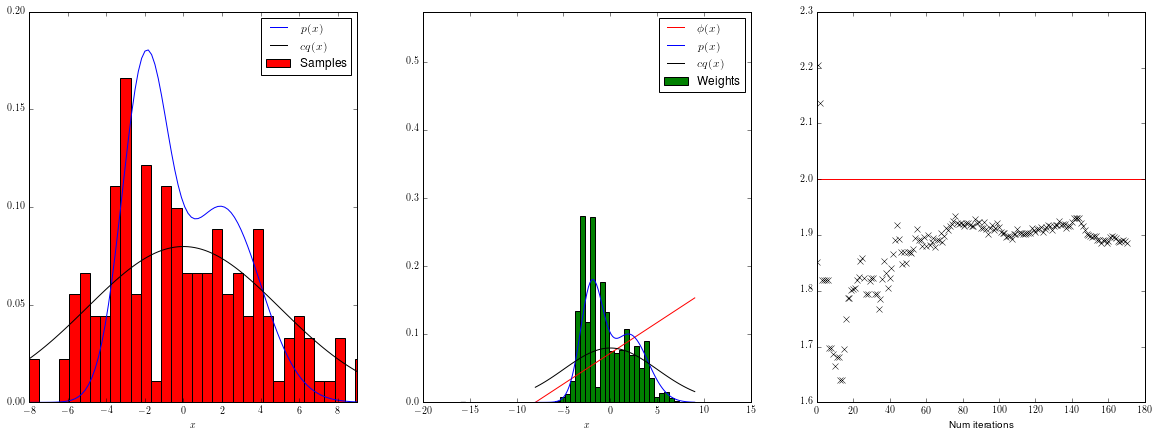

In [13]:

#Set up distributions and phi(x)
target_distr = MixtureOfGaussians(2, [-2, 2], [1.2, 2])
prop_distr = PropDistr(1,distr_type='gaussian',mean=0,sd=5)
phi = Phi(m=0.25,b=2)


c = 1.   #Choose this c such that q(x) is approximately equal to p(x)


#Set up distributions and Phi(x)
x_min = -8
x_max = 9
x = np.linspace(x_min,x_max,100)

#Evaluate distributions and phi(x) at number of points
p_x = target_distr.pdf(x)
scale = (5/np.max(p_x))     #Constant to scale middle plot for vis purposes
q_x = prop_distr.pdf(x)
cq_x = c*q_x
phi_x = phi(x)

#Display target and proposal distributions for given c
plt.plot(x,p_x,'r')
plt.plot(x,cq_x,'b')
plt.show()

input("Paused. Press Enter to continue...")
plt.clf()


#Plot distributions and Phi(x)
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,7)
ax_distr = axes[0]
ax_linfunc = axes[1]
ax_mean = axes[2]

ax_distr.plot(x,p_x,'b',label=r'$p(x)$')
ax_distr.plot(x,cq_x,'k',label=r'$cq(x)$')
ax_distr.set_xlim(xmin=x_min,xmax=x_max)
ax_distr.set_ylim(ymin=0)
ax_distr.axhline(0,color='k')
ax_distr.set_xlabel(r'$x$')
ax_linfunc.plot(x,phi_x/scale,'r',label=r'$\phi(x)$')
ax_linfunc.plot(x,p_x,'b',label=r'$p(x)$')
ax_linfunc.plot(x,cq_x,'k',label=r'$cq(x)$')
ax_linfunc.set_xlabel(r'$x$')
ax_mean.axhline(target_distr.expect(phi),color='r',label=r'True mean')
ax_mean.set_xlabel(r'Num iterations')

num_samples = 500
mean_est = 0
weights_sum = 0     #Sum of the weights for each sample
mean_sum = 0        #Weighted sum of phi(x^(t))
mean_ests =[]
samples =[]
weights = np.array([])

runTillEnd = False
for i in range(num_samples):
    
    sample = prop_distr.rvs()
    samples.append(sample)
    imp_weight = target_distr.pdf(sample)/(c*prop_distr.pdf(sample))
    weights = np.append(weights,np.array([sample, imp_weight])).reshape(-1,2)
    
    mean_sum += phi(sample)*imp_weight 
    weights_sum += imp_weight
    
    mean_est = mean_sum/weights_sum
    mean_ests.append(mean_est)
    
    #Plotting
    display.clear_output(wait=True)

    if i > 0:
        del ax_distr.patches[:]
        del ax_linfunc.patches[:]
    
    ax_distr.hist(samples,min(i+1,50),color='red',normed=True,label=r'Samples')
    n, _, _ = ax_linfunc.hist(weights[:,0],min(i+1,50),weights=weights[:,1],color='green',normed=True,label=r'Weights')
    ax_linfunc.set_ylim((0,np.max(n)+0.3))
    ax_mean.plot(i,mean_est,'kx',label=r'$\hat{\phi}$')
    
    if i == 0:
        ax_distr.legend()
        ax_linfunc.legend()
        ax_mean.plot()
        
    display.display(plt.gcf())
    
    if not runTillEnd:
        if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
            runTillEnd = True


display.clear_output(wait=True)
print("Mean estimate: ", mean_est)
print("True mean: ", target_distr.expect(phi))

Now let's see a failure mode of importance sampling. If we choose a $q(x)$ that is unimodal given a multimodal $p(x)$ where the bulk of $q(x)$ doesn't cover $p(x)$, we shoul get bad estimates of the mean for the same number of sample runs as the case above. 

Try it out and see how the mean estimate varies. Can you explain the jumps?

KeyboardInterrupt: 

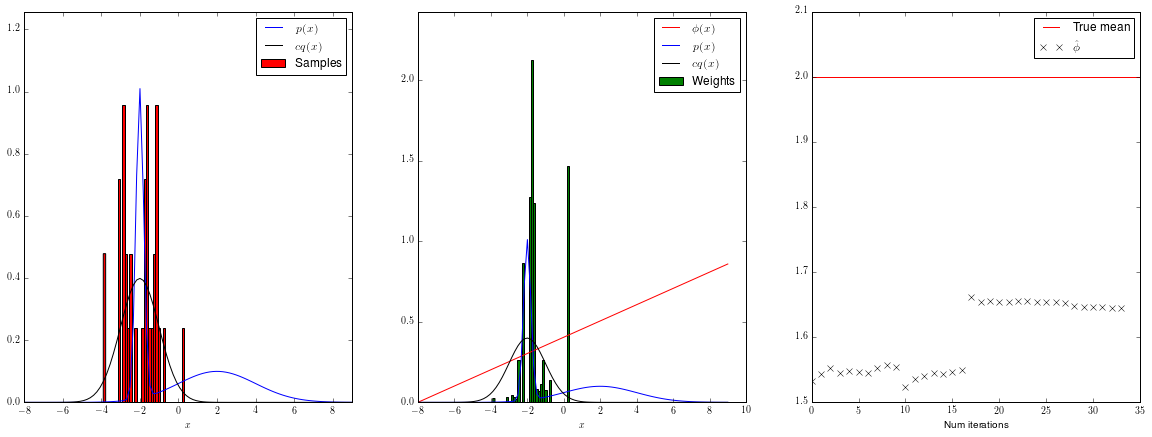

In [14]:

target_distr = MixtureOfGaussians(2, [-2, 2], [.2, 2])
prop_distr = PropDistr(1,distr_type='gaussian',mean=-2,sd=1)
phi = Phi(m=0.25,b=2)


c = 1.   #Choose this c such that q(x) is approximately equal to p(x)


#Set up distributions and Phi(x)
x_min = -8
x_max = 9
x = np.linspace(x_min,x_max,100)
p_x = target_distr.pdf(x)
scale = (5/np.max(p_x))     #Constant to scale middle plot for vis purposes
q_x = prop_distr.pdf(x)
cq_x = c*q_x
phi_x = phi(x)

#Display target and proposal distributions for given c
plt.plot(x,p_x,'r')
plt.plot(x,cq_x,'b')
plt.show()

input("Paused. Press Enter to continue...")
plt.clf()


#Plot distributions and Phi(x)
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,7)
ax_distr = axes[0]
ax_linfunc = axes[1]
ax_mean = axes[2]

ax_distr.plot(x,p_x,'b',label=r'$p(x)$')
ax_distr.plot(x,cq_x,'k',label=r'$cq(x)$')
ax_distr.set_xlim(xmin=x_min,xmax=x_max)
ax_distr.set_ylim(ymin=0)
ax_distr.axhline(0,color='k')
ax_distr.set_xlabel(r'$x$')
ax_linfunc.plot(x,phi_x/scale,'r',label=r'$\phi(x)$')
ax_linfunc.plot(x,p_x,'b',label=r'$p(x)$')
ax_linfunc.plot(x,cq_x,'k',label=r'$cq(x)$')
ax_linfunc.set_xlabel(r'$x$')
ax_mean.axhline(target_distr.expect(phi),color='r',label=r'True mean')
ax_mean.set_xlabel(r'Num iterations')

num_samples = 500
mean_est = 0
weights_sum = 0     #Sum of the weights for each sample
mean_sum = 0        #Weighted sum of phi(x^(t))
mean_ests =[]
samples =[]
weights = np.array([])   #2-D array where first column is location of sample and second is the importance weight

runTillEnd = False
for i in range(num_samples):
    
    sample = prop_distr.rvs()
    samples.append(sample)
    imp_weight = target_distr.pdf(sample)/(c*prop_distr.pdf(sample))
    weights = np.append(weights,np.array([sample, imp_weight])).reshape(-1,2)
    
    mean_sum += phi(sample)*imp_weight 
    weights_sum += imp_weight
    
    mean_est = mean_sum/weights_sum
    mean_ests.append(mean_est)
    
    #Plotting
    display.clear_output(wait=True)

    if i > 0:
        del ax_distr.patches[:]
        del ax_linfunc.patches[:]
    
    n, _, _ = ax_distr.hist(samples,min(i+1,50),color='red',normed=True,label=r'Samples')
    ax_distr.set_ylim((0,np.max(n)+0.3))
    n, _, _ = ax_linfunc.hist(weights[:,0],min(i+1,50),weights=weights[:,1],color='green',normed=True,label=r'Weights')
    ax_linfunc.set_ylim((0,np.max(n)+0.3))
    ax_mean.plot(i,mean_est,'kx',label=r'$\hat{\phi}$')
    
    if i == 0:
        ax_distr.legend()
        ax_linfunc.legend()
        ax_mean.legend()
        
    display.display(plt.gcf())
    
    if not runTillEnd:
        if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
            runTillEnd = True


display.clear_output(wait=True)
print("Mean estimate: ", mean_est)
print("True mean: ", target_distr.expect(phi))

---

## 2. Markov Chain Monte Carlo (MCMC)

The performance of the previous two methods depends on how good a $q(\mathbf{x})$ we choose which is often difficult or impossible in practice. 

So instead of using independent sampling, we use a \textit{Markov Chain} to generate \textit{dependent} samples from the target distribution.

---

---
### 2.1 Metropolis-Hastings
---

The Metropolis-Hastings algorithm makes use of a proposal distribution $q$ that is dependent on the current state $\mathbf{x}^{(\tau)}$. 

The algorithm then works as follows:
$\newcommand\given[1][]{\:#1\vert\:}$
\begin{itemize}
\item Propose a new state $\mathbf{x}^{\*}$ from $q(\mathbf{x}^{\*} \given{\mathbf{x}^{(\tau)}})$
\item Compute the \textit{acceptance probability} $a$:
$$
a = \frac{p(\mathbf{x}^{\*})}{p(\mathbf{x}^{(\tau)})}\frac{q(\mathbf{x}^{(\tau)}\given{\mathbf{x}^{\*}})}{q(\mathbf{x}^{\*}\given{\mathbf{x}^{(\tau)}})}
$$
\item If $a > 1$ then the proposed state is accepted, otherwise the proposed state is accepted with probability $a$. If the proposed state is accepted then $\mathbf{x}^{(\tau+1)} = \mathbf{x^{\*}}$ otherwise $\mathbf{x}^{(\tau+1)} = \mathbf{x^{(\tau)}}$.
\end{itemize}

---

#### 2.1.1 1-D example

The code below sets up a 1-D MoG target distribution with a proposal $q(\mathbf{x}^{*}\given{\mathbf{x}}^{(\tau)})$ that is the same for every state (this can be chosen to be any of the suitable distributions given in the scipy.stats package with the appropriate changes to parameters applied).

The algorithm is then run for a given number of samples (\textbf{num_samples}) and the plots are updated at regular intervals defined by \textbf{step_size}. The left plot (\textbf{ax_distr}) shows the current $q(\mathbf{x}^{*}\given{\mathbf{x}}^{(\tau)})$ (scaled version) with vertical lines to indicate the current state (black) and the corresponding sample (magenta), a scaled histogram showing the distribution of accepted samples, the scaled target distribution and the linear function $\phi(x)$.

KeyboardInterrupt: 

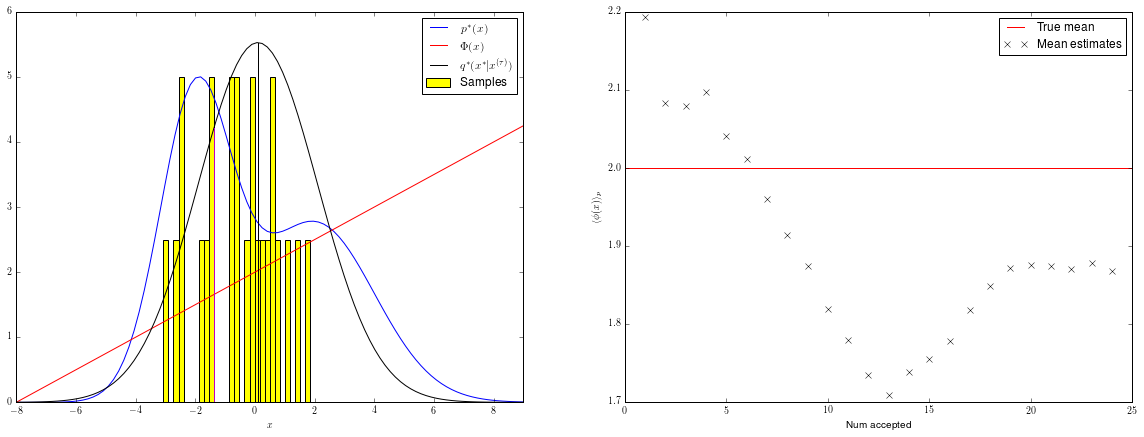

In [16]:

#Set up distributions and phi(x)
target_distr = MixtureOfGaussians(2, [-2, 2], [1.2, 2])
mean_init = 0   #Initial state
sd = 2.0  #Standard deviation - same for each state
prop_distr = norm #MixtureOfGaussians(2,[-1,1], [0.1,0.1])#
phi = Phi(m=0.25,b=2)



#Evaluate distributions and phi(x)
x_min = -8
x_max = 9
x = np.linspace(x_min,x_max,100)

p_x = target_distr.pdf(x)
targetMax = 5
scale = (targetMax/np.amax(p_x))
ps_x = scale*p_x     #p*(x)
q_x = prop_distr.pdf(x, mean_init,sd)
qs_x = scale*q_x     #q*(x)
phi_x = phi(x)



#Plot distributions and phi(x)
fig, axes = plt.subplots(1,2)
fig.set_size_inches(20,7)
ax_distr = axes[0]
ax_mean = axes[1]

ax_distr.plot(x,ps_x,'b',label=r'$p^{*}(x)$')
ax_distr.plot(x,qs_x,'k',label=r'$q^{*}(x^{*}|x^{(\tau)})$')
ax_distr.plot(x,phi_x,'r',label=r'$\Phi(x)$')
ax_distr.set_xlim(xmin=x_min,xmax=x_max)
ax_distr.set_ylim(ymin=0.0)
ax_distr.set_xlabel(r'$x$')
ax_distr.legend()
ax_mean.axhline(target_distr.expect(phi),color='r',label=r'True mean')
ax_mean.set_xlabel("Num accepted")
ax_mean.set_ylabel(r'$\langle\phi(x)\rangle_{p}$')
ax_mean.legend()
display.display(plt.gcf())
input("Paused. Press enter to continue...")
del ax_distr.lines[-2]    



num_samples = 2500
mean_est = 0
num_accepts = 0
step_size = 1     #Intervals at which to update plots
mean_ests =[]       #Mean estimates at each time step
accepted = []
rejected = []
samples = []

curr_state = mean_init    #x(0) sample

runTillEnd = False
for i in range(num_samples):
    
    cand_samp = prop_distr.rvs(curr_state)  #Candidate next state
    samples.append(cand_samp)
    
    a = min(1,\
            (prop_distr.pdf(curr_state,cand_samp,sd)/prop_distr.pdf(cand_samp,curr_state,sd))*\
                    (target_distr.pdf(cand_samp)/target_distr.pdf(curr_state)))
    
    #Check if sample is accepted
    u = np.random.rand()
    if u < a:
        accepted.append(cand_samp)
        
        mean_est = mean_est*(num_accepts/(num_accepts+1)) +\
                (phi(cand_samp))/(num_accepts+1)
        mean_ests.append(mean_est)
        num_accepts += 1               
    else:
        rejected.append(cand_samp)
    
    #Update plot
    if (i%step_size == 0 or i==num_samples-1):
        
        display.clear_output(wait=True)
             
        if i//step_size > 0:
            del ax_distr.lines[-3:]  #Delete previous q(x'|x)
            del ax_distr.patches[:]  #Delete previous histogram
            del ax_mean.lines[-1]    #Delete previous mean estimate evolution
        
        ymin, ymax = ax_distr.get_ylim()
        ax_distr.plot(x,scale*prop_distr.pdf(x,curr_state,sd),'k',label=r'$q^{*}(x^{*}|x^{(\tau)})$')
        ax_distr.axvline(curr_state,ymax=(scale*prop_distr.pdf(curr_state,curr_state,sd)-ymin)/(ymax-ymin),color='k')
        ax_distr.axvline(cand_samp,ymax=(scale*prop_distr.pdf(cand_samp,curr_state,sd)-ymin)/(ymax-ymin),color='m')
        
        n, _, _ = ax_distr.hist(accepted,100,range=(x_min,x_max),normed=True,color='yellow',label=r'Samples')
            
        #Rescale histograms to match target distrbutions
        maxbin = np.argmax(n)
        histScale = (targetMax/ax_distr.patches[maxbin].get_height())
        for patch in ax_distr.patches:
            patch.set_height(histScale*patch.get_height())
                 
        ax_mean.plot(np.arange(1,num_accepts+1),mean_ests,'kx',label=r'Mean estimates')
        
        if num_accepts==1:
            ax_distr.legend()
            ax_mean.legend()
            
        display.display(plt.gcf())
        
        if not runTillEnd:
            if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
                runTillEnd = True
        
    
    #Update current state
    if u < a:
        curr_state = cand_samp
        
display.clear_output(wait=True)
print("Num rejected: ",len(rejected))
print("Num accepted: ",len(accepted))
print("Mean estimate: ", mean_est)
print("True mean: ", target_distr.expect(phi))

---

#### 2.1.2 2-D example

The example primarily shows how sampling occurs in two dimensions so as to illustrate the intuition behind the algorithm.

We first define a new class for a D-dimensional mixture of Gaussians that makes the following code easy to modify. 

In [17]:
class MixtureOfGaussiansII(object):
    """
        Defines a Mixture of Gaussians distribution
    """
    def __init__(self, D, K, means, cov, weights=None):
        """
            D - No. of dimensions
            K - No. of means
            means - The means for each Gaussian. Should have shape (K, D)
            cov - The covariance matrices. Can be:
                   - For diagonal case, shape is (K,) (same variance in all dims) 
                           or (K,D) (different var for each dim).
                   - For full covariance, shape is (K,D,D) or it can be (1,D,D) to signify
                     that each Gaussian has same covariance matrix.
            weight - Mixture weights for each Gaussian - shape(K,)
        """
        self.D = D
        self.K = K
        self.means = np.array(means).reshape(-1,D)
        self.cov = np.array(cov)
        
        #If we specify a single covar matrix (for (K,D,D) case) we repeat it for each Gaussian in mixture
        print(self.cov.shape[0])
        if self.cov.shape[0] != K:
            self.cov = np.tile(self.cov,(K,1,1))
            
        if weights == None:
            self.weights = np.ones(K)/K
        else:
            self.weights = weights
            
        #Choose which distribution to use
        if D == 1:
            self.distr = norm
        else:
            self.distr = multivariate_normal
        
    
    def pdf(self, x):
        """
            Evaluate the pdf at the given x
        """
        
        pdf_x = 0
        
        for i in range(self.K):
            pdf_x += self.weights[i]*self.distr.pdf(x,self.means[i],self.cov[i])
            
        return pdf_x
        

def plotGaussianEllipse(ax, mean, cov, ellipsecolor,zorder=2):
    """
        Plots an ellipse representing the covariance matrix of a Gaussian.
        
        Args:
            ax - The Axes object on which to plot the ellipses
            m - The centre of the ellipse
            V - Covariance matrix
            ellipsecolor - Ellipse color border colour
    """
    
    #Reshape arrays to
    s = 4.605  #90% confidence interval
    eigVals, eigVecs = np.linalg.eig(cov)
    
    #Sort eigvalues to make sure that large eigval is first
    idx = eigVals.argsort()[::-1]

    eigVals = eigVals[idx]
    eigVecs = eigVecs[:,idx]
        
    #Add ellipse to axes
    border = patches.Arc(xy=mean,width = 2*(s*eigVals[0])**0.5,height = 2*(s*eigVals[1])**0.5,
                        angle=np.degrees(np.arctan2(eigVecs[1,0],eigVecs[0,0])), \
                         linewidth=0.5, linestyle='-',color=ellipsecolor,fill=False, zorder=zorder)
    ax.plot(mean[0],mean[1],'x',c=ellipsecolor,markersize=10)
    ax.add_patch(border)

def plotDistributionContour(ax, X, Y, pdf, levels, color,zorder=100,label=""):
    """
        Plots a contour for a probability distribution
        
        Args:
            ax - The Axes object on which to plot contour
            X, Y - The x-axis and y-axis points. 
            pdf - The evaluation of the distribution at points on a 2x2 grid
            levels - The levels at which to draw contour lines
            color - Color of the lines
    """
    
    ax.contour(X,Y,pdf,levels=levels,colors=color,zorder=zorder,label=label)
    
    

KeyboardInterrupt: 

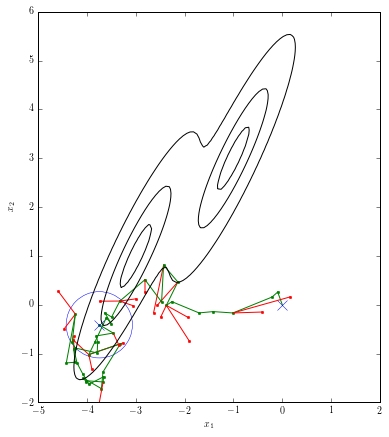

In [18]:

D = 2  #Dimension of problem
K = 2  #Number of components
#Set up target and proposal distributions
target_distr = MixtureOfGaussiansII(D, K, [[-3, 1],[-1,3]], [[[0.5, 0.9],[0.9, 2.0]]])
prop_mean_init = np.array([0,0])
prop_cov = np.array([[0.1, 0],[0, 0.1]])  #Constant for each state
prop_distr = multivariate_normal

#Set up (x,y) coordinates
xmin = -5
xmax = 2
ymin = -2
ymax = 6
num_points=100
x = np.linspace(xmin,xmax,num_points)
y = np.linspace(ymin,ymax,num_points)
X, Y = np.meshgrid(x,y)

#Evaluate target distribution on 2-D grid
Z = target_distr.pdf(np.append(X.reshape(-1,1),Y.reshape(-1,1),axis=1)).reshape(num_points,num_points)

#Set up plot Display target and proposal distributions
fig, ax_distr = plt.subplots()
fig.set_size_inches(20,7)
maxZ = np.max(Z)
plotDistributionContour(ax_distr,X,Y,Z,levels=[0.0,0.2*maxZ,0.6*maxZ,0.9*maxZ],color='black',zorder=100,label=r'p(\mathbf{x})')
ax_distr.set_xlabel(r'$x_{1}$')
ax_distr.set_ylabel(r'$x_{2}$')
plotGaussianEllipse(ax_distr, prop_mean_init, prop_cov, 'blue')
ax_distr.set_xlim((-5,2))
ax_distr.set_ylim((-2,6))
ax_distr.set_aspect('equal', adjustable='box')
display.display(plt.gcf())
input("Paused. Press Enter to continue...")



num_samples = 2500
num_accepts = 0
step_size = 1
accepted = []
rejected = []
samples = []

#x(0) sample
curr_state = prop_mean_init
print("curr_state: ", curr_state)

dispAtEnd = False     #Set to true to only plot after simulation
runTillEnd = False
for i in range(num_samples):
    
    cand_samp = prop_distr.rvs(curr_state, prop_cov)  #Candidate next state
    samples.append(cand_samp)
 
    alpha = min(1,(prop_distr.pdf(curr_state,mean=cand_samp,cov=prop_cov)/\
                   prop_distr.pdf(cand_samp,mean=curr_state,cov=prop_cov))*\
                      (target_distr.pdf(cand_samp)/target_distr.pdf(curr_state)))
    
    
    if not runTillEnd:
        if input("Press enter to continue, 'rte' to run simulation to end: ") == "rte":
            runTillEnd = True
        
    
    #Plot proposal ellipse  
    display.clear_output(wait=True)
    del ax_distr.patches[-1]  #Delete previous ellipse
    plotGaussianEllipse(ax_distr, curr_state, prop_cov,'blue')
    if not dispAtEnd:
        display.display(plt.gcf())
    
            
    #Delete previous centre
    del ax_distr.lines[-1]
    
    u = np.random.rand()
    if u < alpha:
        accepted.append(cand_samp)
        
        #Plot accepted sample
        ax_distr.plot(cand_samp[0],cand_samp[1],'k.',markersize=5,color='green')
        ax_distr.plot([cand_samp[0], curr_state[0]],[cand_samp[1], curr_state[1]],'-',color='green')

        num_accepts += 1
        
        curr_state = cand_samp
    else:
        rejected.append(cand_samp)
        
        #Plot rejected sample
        ax_distr.plot(cand_samp[0],cand_samp[1],'k.',markersize=5,color='red')
        ax_distr.plot([cand_samp[0], curr_state[0]],[cand_samp[1], curr_state[1]],'-',color='red')

del ax_distr.patches[-1]
display.clear_output(wait=True)    
print("Number of rejected samples: ", len(rejected))
print("Number of accepted samples: ", len(accepted))


##### Problems

1. Try different covariance matrices of the proposal to see how quickly we get a suitable number of accepted samples.

---
### 2.2 Gibb's Sampling
---

Another MCMC sampling method that is closely related to the Metropolis-Hastings algorithm is  \textit{Gibb's sampling}. It can be seen as a Metropolis-Hastings method whereby the proposal distributions are defined in terms of conditional distributions of the joint $p(\mathbf{x})$. Therefore, for the method to work, we only need to ensure that the conditional distributions are tractable to work with.

With Gibb's, we sample each parameter from $q(x^{'}_{i}\given{\mathbf{x}}) = p(x^{'}_{i}\given{x_{\neq i}})$. This then gives as an acceptance probability, $a$ (like the Metropolis-Hastings method):

$$
a = \min\left(1,\frac{p(x_{\neq i})p(x^{'}_{i}\given{x_{\neq i}})}{p(x^{'}_{i})p(x_{\neq i}\given{x^{'}_{i}})}\right) = 1
$$

This always accepts and so the algorithm can be viewed as the Metropolis-Hastings algorithm with $a=1$ where we sample one parameter at a time conditioning on the current state of all other parameters. 

---

For the code below, we use MoG conditional distributions and so for each sample, we need to calculate the parameters of the conditional MoG and sample from it as part of the algorithm. We then plot the conditional distribtuion for each sample showing how the next sample is obtained so as to illustrate the intuition behind the algorithm.

In [19]:
def calcCondGaussian(mu_1,mu_2,x_2,S_11,S_21,S_1222):
    """
        Calculates the conditional distribution, p(x_1|x_2) of a multivariate Gaussian p(x_1,x_2).
        
        Args:
            mu_1 - Mean for x_1
            mu_2 - Mean for x_2
            x_2 - Current value of x_2
            S_11 - Sigma_11
            S_21 - Sigma_21
            S_1222 - Sigma_12*(Sigma_22^-1)
            
        Outputs:
            mu_12 - E[x_1|x_2]
            Sig_12 - Cov[x_1|x_2]
    """
    
    mu_12 = mu_1 + S_1222*(x_2-mu_2)
    Sig_12 = S_11 - S_1222*S_21
    
    return mu_12, Sig_12
    

KeyboardInterrupt: 

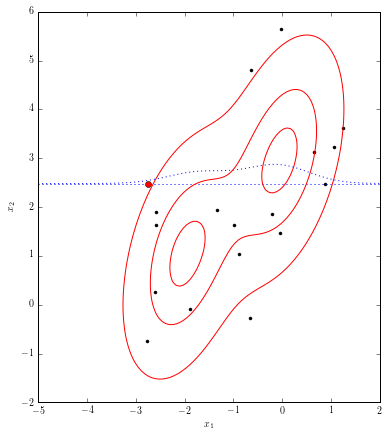

In [20]:
D = 2  #Dimension of problem. LEAVE AS D=2
K = 2  #Number of mixture components
target_distr = MixtureOfGaussiansII(D, K, [[-2, 1],[0, 3]], [[[0.5, 0.4],[0.4, 2.0]]])

#Set up (x,y) coordinates
ax_xmin, ax_xmax = -5, 2
ax_ymin, ax_ymax = -2, 6
num_points=100
x = np.linspace(ax_xmin,ax_xmax,num_points)
y = np.linspace(ax_ymin,ax_ymax,num_points)
X, Y = np.meshgrid(x,y)

#Evaluate target distribution on 2-D grid
Z = target_distr.pdf(np.append(X.reshape(-1,1),Y.reshape(-1,1),axis=1)).reshape(num_points,num_points)

#Display target and proposal distributions for calculated c
fig, ax_distr = plt.subplots()
fig.set_size_inches(20,7)
maxZ = np.max(Z)
plotDistributionContour(ax_distr,X,Y,Z,levels=[0.0,0.2*maxZ,0.6*maxZ,0.9*maxZ],\
                        color='red',zorder=100,label=r'$p(\mathbf{x})$')
ax_distr.set_xlabel(r'$x_{1}$')
ax_distr.set_ylabel(r'$x_{2}$')
ax_distr.set_xlim((ax_xmin, ax_xmax))
ax_distr.set_ylim((ax_ymin, ax_ymax))
ax_distr.set_aspect('equal', adjustable='box')
display.display(plt.gcf())
input("Paused. Press Enter to continue...")


num_samples = 2500
samples = []
    
#x(0) sample
curr_state = multivariate_normal.rvs(mean=[-1,2],cov=0.1)
print("curr_state: ", curr_state)

runTillEnd = False
for i in range(num_samples):
    
    samples.append(curr_state)
    
    #First sample
    mu_12 = list()
    sd_12 = list()
    for k in range(K):
        mu_1 = target_distr.means[k][0]
        mu_2 = target_distr.means[k][1]
        Sigma_11 = target_distr.cov[k][0,0]
        Sigma_12 = target_distr.cov[k][0,1]
        Sigma_21 = target_distr.cov[k][1,0]
        Sigma_22 = target_distr.cov[k][1,1]
        mu_k, Sig_k = calcCondGaussian(mu_1,mu_2,curr_state[1],Sigma_11,Sigma_21,Sigma_12/Sigma_22)
        mu_12.append(mu_k)
        sd_12.append(math.sqrt(Sig_k))
   
    display.clear_output(wait=True)

    cond_weights = target_distr.weights*norm.pdf(curr_state[1],target_distr.means[:,1],\
                                                 np.sqrt(target_distr.cov[:,1,1]))

    cond_weights /= np.sum(cond_weights)

    # NOTE: This should not be 'MixtureofGaussiansII'
    cond_distr = MixtureOfGaussians(K, mu_12, sd_12, cond_weights)
    x1_samp = cond_distr.rvs()

    #Plot current point
    ax_distr.plot(curr_state[0],curr_state[1],'k.')
    
    #Plot conditional distribution
    ax_distr.plot(x,cond_distr.pdf(x)+curr_state[1],'b:')
    ax_distr.axhline(curr_state[1],xmin=(x[0]-ax_xmin)/(ax_xmax-ax_xmin),\
                     xmax=(x[-1]-ax_xmin)/(ax_xmax-ax_xmin),ls=':',color='blue')
    ax_distr.plot(x1_samp,curr_state[1],'ro')
    
    display.display(plt.gcf())
    
    if not runTillEnd:
        if input("Press enter to continue. Type 'rte' to run simulation to end. ") == "rte":
            runTillEnd = True
    del ax_distr.lines[-3]    #Pdf plot
    
    
    #Second sample
    mu_21 = list()
    sd_21 = list()
    for k in range(K):
        mu_1 = target_distr.means[k][0]
        mu_2 = target_distr.means[k][1]
        Sigma_11 = target_distr.cov[k][0,0]
        Sigma_12 = target_distr.cov[k][0,1]
        Sigma_21 = target_distr.cov[k][1,0]
        Sigma_22 = target_distr.cov[k][1,1]
        mu_k, Sig_k = calcCondGaussian(mu_2,mu_1,x1_samp,Sigma_22,Sigma_12,Sigma_21/Sigma_11)
        mu_21.append(mu_k)
        sd_21.append(math.sqrt(Sig_k))
    
    cond_weights = target_distr.weights*norm.pdf(x1_samp,target_distr.means[:,0],\
                                                        np.sqrt(target_distr.cov[:,0,0]))
    cond_weights /= np.sum(cond_weights)
    
    # NOTE: This should not be 'MixtureofGaussiansII'
    cond_distr = MixtureOfGaussians(K, mu_21, sd_21, cond_weights)
    x2_samp = cond_distr.rvs()
    
    display.clear_output(wait=True)
    
    #Plot conditional
    ax_distr.plot(cond_distr.pdf(y)+x1_samp,y,'b:')
    ax_distr.axvline(x1_samp,ymin=(y[0]-ax_ymin)/(ax_ymax-ax_ymin),\
                    ymax=(y[-1]-ax_ymin)/(ax_ymax-ax_ymin),ls=':',color='blue')
    ax_distr.plot(x1_samp,x2_samp,'ro')
    
    #Plot next point
    ax_distr.plot(x1_samp,x2_samp,'k.')
    
    
    display.display(plt.gcf())
    
    
    #Update state
    curr_state = np.array([x1_samp, x2_samp]) 
    
    
    if not runTillEnd:
        if input("Press enter to continue. Type 'rte' to run simulation to end. ") == "rte":
            runTillEnd = True
    del ax_distr.lines[-6:]
    

samples = np.array(samples)
ax_distr.plot(samples[:,0],samples[:,1],'g.')